## DPP Final Project - Analysis

### 1. Performance

#### 1.1. Isomoprhism check

In the paper, the Minimum DFS Code (M-DFS) is adopted to recognize and match isomorphic components when analyzing the neighborhood of a pair of nodes. However, the computational complexity of generating the exact Minimum DFS Code is factorial O(N!) in the worst case. This worst-case scenario occurs in a clique (i.e., a complete graph). Starting from the first node, there are N−1 choices for the next step; at the second node, there are N−2 choices, and so on. This results in (N−1)! different DFS traces to compare. While the search can be pruned by comparing the current trace with the best one found so far (discarding it if it is lexicographically larger), the exact calculation remains computationally prohibitive.  For this reason, while the code for producing the exact M-DFS is provided, it is not used in the `SocialAnonymizer` class.

Heuristics limiting the search space for determining the minimum DFS code can be used. However, by definition, heuristics may not spot the actual minimum code and yield a non-minimum code for graphs. As a consequence, they can produce false negatives (i.e., isomorphic graphs not recognized as such) or/and false positives (i.e., non-isomorphic graphs recognized as such). False positives are a threat to privacy because in the algorithm perfect component matches are not further manipulated to reach isomoprhism since they are considered already isomoprhic. Hence, the occurrence of false positives may leave in the final anonymized graph some nodes whose neighborhood is unique. Therefore, neighborhood attacks can be performed on those nodes. On the other hand, false negatives are not a problem, because, if the components are matched correctly by `most_similar_component` and the mapping satisfying isomoprhism is found, then `make_components_isomorphic` will apply no changes to the components, maintaining isomoprhism. However, if the false negatives are not paired correctly by `most_similar_component` or a wrong mapping is used, the algorithm leads to overanonymization (i.e., adding edges or generalizing label when not strictly necessary, causing an unnecessary information loss). Hence, heuristics admitting only false negatives can be adopted to speed up the process at the cost of utility. 

The NetworkX library provides the `is_isomorphic` method, which implements the VF2 algorithm described by L. P. Cordella et al. (2001). Like M-DFS, the algorithm is exact (producing neither false positives nor false negatives) and has a factorial worst-case complexity. However, on average, it is considerably faster than a custom Python implementation of M-DFS due to its highly optimized state-space pruning mechanism. For this reason, it was adopted in this project to replace M-DFS for isomorphism checks.

In [4]:
import random
from utils import positive_benchmark

random.seed(42)

# Run the experiment
ns = [10, 15, 20, 25]
seeds = [random.randint(0, 100) for _ in range(5)]
p = 0.2

pos_MDFS_times, pos_vf2_times = positive_benchmark(ns, p, seeds)

Graph size: 100%|██████████| 4/4 [10:22<00:00, 155.60s/it]


In [5]:
from utils import negative_benchmark

# Run the experiment
ns = [10, 15, 20, 25]
seeds = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(5)]
p = 0.2

neg_MDFS_times, neg_vf2_times = negative_benchmark(ns, p, seeds)

Graph size: 100%|██████████| 4/4 [13:29<00:00, 202.28s/it]


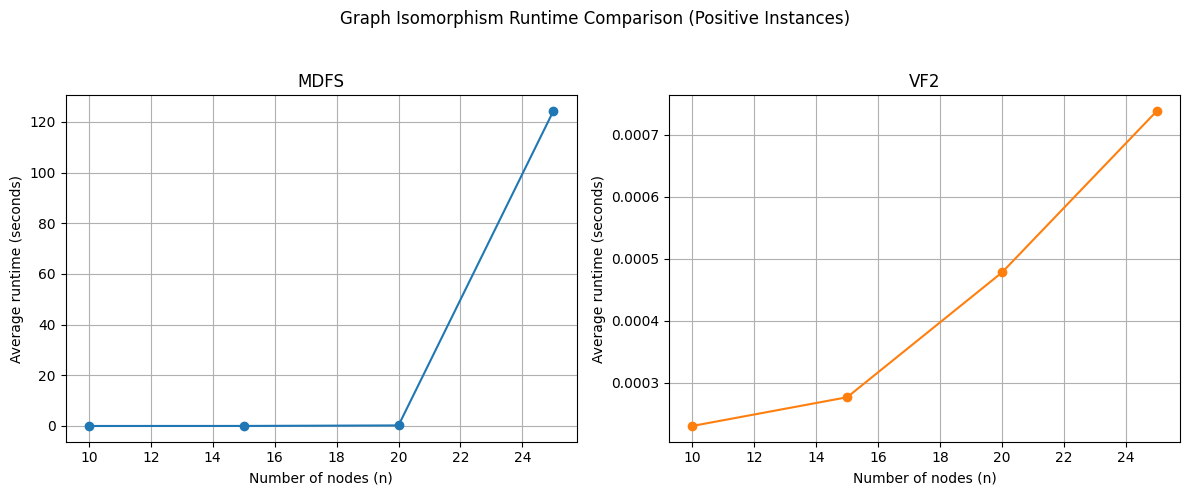

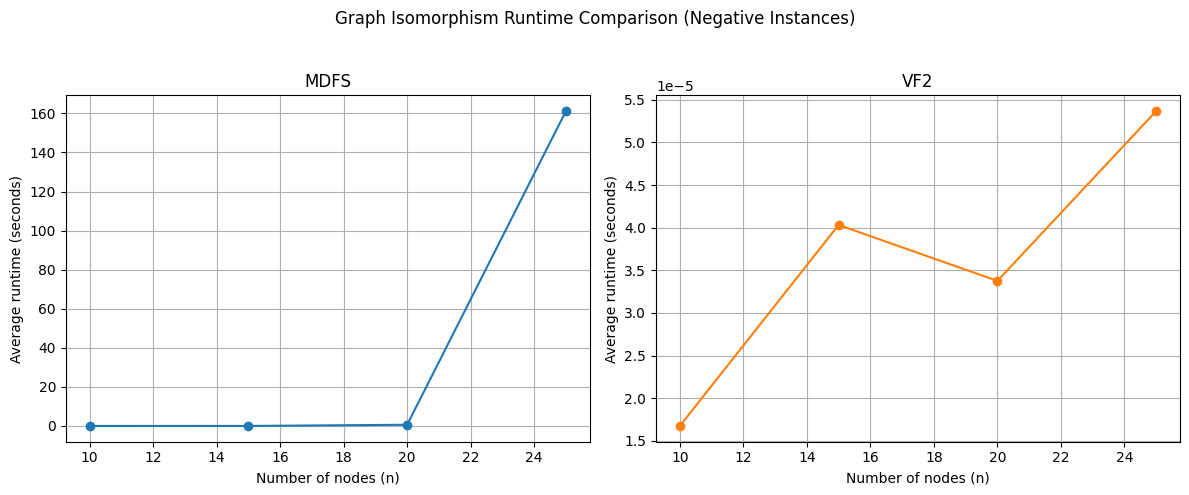

In [7]:
import matplotlib.pyplot as plt

def plot_runtime_comparison(ns, times_a, times_b, label_a, label_b, suptitle):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(ns, times_a, marker='o', color='tab:blue')
    axes[0].set_title(label_a)
    axes[0].set_xlabel('Number of nodes (n)')
    axes[0].set_ylabel('Average runtime (seconds)')
    axes[0].grid(True, which='both')

    axes[1].plot(ns, times_b, marker='o', color='tab:orange')
    axes[1].set_title(label_b)
    axes[1].set_xlabel('Number of nodes (n)')
    axes[1].set_ylabel('Average runtime (seconds)')
    axes[1].grid(True, which='both')

    plt.suptitle(suptitle)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_runtime_comparison(ns, pos_MDFS_times, pos_vf2_times,
    label_a='MDFS', label_b='VF2',
    suptitle='Graph Isomorphism Runtime Comparison (Positive Instances)'
    )

plot_runtime_comparison(ns, neg_MDFS_times, neg_vf2_times,
    label_a='MDFS', label_b='VF2',
    suptitle='Graph Isomorphism Runtime Comparison (Negative Instances)'
    )

When detecting positive instances, the average runtime for both algorithms is monotonic with respect to the number of nodes. However, for negative instances, the VF2 average runtime is not monotonic.   

The reason for this difference lies in how the algorithms terminate. For VF2 to confirm two graphs are isomorphic (positive), it searches until it finds the first valid mapping; as graph size increases, finding this mapping generally takes longer, leading to monotonic growth. For negative instances, VF2's performance is highly dependent on the specific input. If the graphs have different structural invariants (e.g., node counts or degree sequences), VF2 detects the difference and rejects the pair almost instantly, regardless of graph size. However, if the graphs are structurally similar but not isomorphic, VF2 must explore the search space more deeply to prove no mapping exists. This variability causes the non-monotonic behavior observed in negative instances.   

On the other hand, the custom isomorphism check first computes the exact Minimum DFS Code for both graphs and only compares them afterward. Because the code generation explores the search space regardless of whether the graphs eventually match, the runtime depends solely on the input graph size and complexity, resulting in a monotonic trend for both positive and negative instances.    

As expected, VF2 performs significantly better than the MDFS implementation, with a difference of five to seven orders of magnitude in average runtime.


#### 1.2. Algorithm time complexity

The paper does not provide a formal time complexity analysis for the anonymization algorithm. However, since the only two operations used to manipulate the graph are edge addition and label generalization, the algorithm is proven to terminate for a finite social network of at least k vertices, as stated in Theorem 4. Indeed, in the worst case, the network is anonymized to a clique.    

Despite the termination guarantee, the time complexity of the `anonymize_graph` function is quite high, primarily due to subgraph isomorphism checks and the restart mechanisms triggered by topology changes in the neighborhoods.
We can identify several costly operations performed by the algorithm:


- Vertex list sorting.
- Candidate selection.
- Group stabilization, where the loop is bounded by the maximum number of edges that can be added to the group's neighborhood.
- The `anonymize_pair` method, which serves as the main bottleneck due to:
    - Component extraction (identifying connected components in the subgraph induced by neighbors).
    - Isomorphism checks.
    - Greedy component matching (picking the largest component and finding the partner with the smallest anonymization cost).
    - The restart loop triggered if components merge.    

The dominant factor is the isomorphism check. Although the VF2 algorithm (used via NetworkX) is generally faster than MDFS, it also scales poorly with high node degree. In VF2, a high degree results in a larger set of candidate pairs at each step of the state-space search and renders the feasibility pruning rules less effective (as high-degree neighborhoods often resemble dense cliques). Consequently, whether using MDFS or VF2, running this algorithm on graphs with high-degree hubs (e.g., influencers in a social network), the algorithm becomes extremely slow. It works best on sparse graphs where the maximum degree d is small.

In [8]:
import time
import networkx as nx
from SocialAnonymizer import SocialAnonymizer

social_anonymizer = SocialAnonymizer()
k_values = [2, 3, 4]
num_of_repetition = 5
seed = 42

##### 1.2.1 Erdős–Rényi model

---------------------
Seed Vertex:  9
Processing group  [9, 1]
Processing pair 9-1
Components of node 9 [NodeView((0, 1, 2, 4, 6, 7, 8))]
Components of node 1 [NodeView((2, 3, 4, 5, 6, 8, 9))]
---------------------
Seed Vertex:  3
Processing group  [3, 8]
Processing pair 3-8
Components of node 3 [NodeView((0, 1, 4, 5, 6, 7, 8))]
Components of node 8 [NodeView((0, 1, 2, 3, 5, 7, 9))]
---------------------
Seed Vertex:  9
Processing group  [9, 4]
Processing pair 9-4
Components of node 9 [NodeView((0, 1, 2, 4, 5, 6, 7, 8))]
Components of node 4 [NodeView((0, 1, 3, 5, 7, 8, 9))]
---------------------
Seed Vertex:  8
Processing group  [8, 7]
Processing pair 8-7
Components of node 8 [NodeView((0, 1, 2, 3, 4, 5, 6, 7, 9))]
Components of node 7 [NodeView((0, 1, 2, 3, 4, 5, 6, 8, 9))]
---------------------
Seed Vertex:  5
Processing group  [5, 6]
Processing pair 5-6
Components of node 5 [NodeView((0, 1, 2, 3, 4, 6, 7, 8, 9))]
Components of node 6 [NodeView((0, 1, 3, 4, 5, 7, 8, 9))]
-----------

<Figure size 640x480 with 0 Axes>

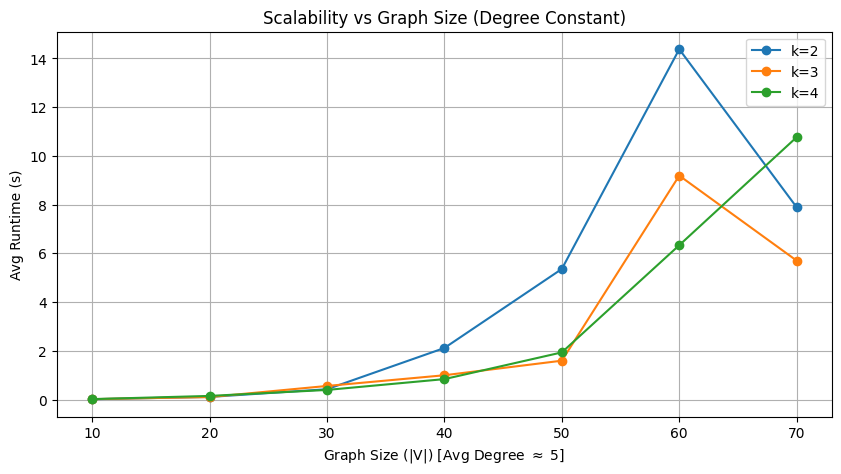

In [11]:
results_size = {k: [] for k in k_values}
graph_sizes = [10, 20, 30, 40, 50, 60, 70]
fixed_avg_degree = 5

for size in graph_sizes:
    p = fixed_avg_degree / (size-1) # because <k> = p*(N-1)

    for k in k_values:

        durations = []
        G_random = nx.gnp_random_graph(n=size, p=p, seed=seed)

        for _ in range(num_of_repetition):  # remove randomness of a single execution

            time_start = time.time()
            G_anon, eq_classes = social_anonymizer.anonymize_graph(G_random, k=k, alpha=0, beta=1, gamma=1)
            time_end = time.time()

            durations.append(time_end - time_start)

        avg_duration = sum(durations) / len(durations)

        results_size[k].append((size, avg_duration))

plt.figure()

plt.figure(figsize=(10, 5))
for k, data in results_size.items():
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Graph Size (|V|) [Avg Degree $\\approx$ {fixed_avg_degree}]")
plt.ylabel("Avg Runtime (s)")
plt.title("Scalability vs Graph Size (Degree Constant)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fixed_size = 70
target_degrees = [2, 4, 6, 8, 10]
results_degree = {k: [] for k in k_values}

for deg in target_degrees:
    p = deg / (fixed_size - 1)
    p = min(p, 1.0) # Ensure p <= 1.0
    
    for k in k_values:
        durations = []
        G_random = nx.gnp_random_graph(n=fixed_size, p=p, seed=seed)

        for i in range(num_of_repetition):
            
            # actual avg degree to be precise in plotting
            actual_deg = sum(dict(G_random.degree()).values()) / fixed_size
            
            start = time.time()
            social_anonymizer.anonymize_graph(G_random, k=k, alpha=0, beta=1, gamma=1)
            end = time.time()
            durations.append(end - start)
            
        avg_time = sum(durations) / len(durations)
        results_degree[k].append((actual_deg, avg_time))

plt.figure(figsize=(10, 5))
for k, data in results_degree.items():
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Average Node Degree [Size = {fixed_size}]")
plt.ylabel("Avg Runtime (s)")
plt.title("Scalability vs Node Density (Size Constant)")
plt.legend()
plt.grid(True)
plt.show() 

---------------------
Seed Vertex:  57
Processing group  [57, 59]
Processing pair 57-59
Components of node 57 [NodeView((1,)), NodeView((34,)), NodeView((36,)), NodeView((45,)), NodeView((63,))]
Components of node 59 [NodeView((1,)), NodeView((32, 4)), NodeView((16,))]
---------------------
Seed Vertex:  63
Processing group  [63, 39]
Processing pair 63-39
Components of node 63 [NodeView((18,)), NodeView((23,)), NodeView((56,)), NodeView((57,))]
Components of node 39 [NodeView((5,)), NodeView((51,)), NodeView((52,)), NodeView((68,))]
---------------------
Seed Vertex:  23
Processing group  [23, 16]
Processing pair 23-16
Components of node 23 [NodeView((6,)), NodeView((9,)), NodeView((63,)), NodeView((69,))]
Components of node 16 [NodeView((46,)), NodeView((59,)), NodeView((66,)), NodeView((67,))]
---------------------
Seed Vertex:  7
Processing group  [7, 36]
Processing pair 7-36
Components of node 7 [NodeView((27,)), NodeView((47,)), NodeView((50,)), NodeView((64,))]
Components of node

##### 1.2.2 Barabasi-Albert model

In [ ]:
results_size = {k: [] for k in k_values}
graph_sizes = [10, 20, 30, 40, 50]
fixed_avg_degree = 6                 # Must be even for integer m calculation

fixed_m = int(fixed_avg_degree / 2) # average degree ~= 2*m

for size in graph_sizes:
    
    if size <= fixed_m: # model constraint: n > m
        continue

    for k in k_values:
        durations = []
        
        G_ba = nx.barabasi_albert_graph(n=size, m=fixed_m, seed=seed)
        for _ in range(num_of_repetition):
            start = time.time()
            social_anonymizer.anonymize_graph(G_ba, k=k, alpha=0, beta=1, gamma=1)
            end = time.time()
            durations.append(end - time_start)

        avg_duration = sum(durations) / len(durations)
        results_size[k].append((size, avg_duration))

plt.figure(figsize=(10, 5))
for k, data in results_size.items():
    if not data: continue
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Graph Size (|V|) [Fixed m={fixed_m} (Avg Deg $\\approx$ {fixed_avg_degree})]")
plt.ylabel("Avg Runtime (s)")
plt.title("Scalability vs Graph Size (BA Model)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
fixed_size = 50
target_degrees = [2, 4, 6, 8, 10, 12] 
results_degree = {k: [] for k in k_values}

for deg in target_degrees:

    m_dynamic = int(deg / 2) # average degree ~= 2*m
    
    # Constraints check
    if m_dynamic < 1: m_dynamic = 1
    if m_dynamic >= fixed_size: continue

    for k in k_values:
        durations = []
        
        avg_actual_degrees = []
        G_ba = nx.barabasi_albert_graph(n=fixed_size, m=m_dynamic, seed=seed)

        for _ in range(num_of_repetition):
            
            actual_deg = sum(dict(G_ba.degree()).values()) / fixed_size
            avg_actual_degrees.append(actual_deg)
            
            start = time.time()
            social_anonymizer.anonymize_graph(G_ba, k=k, alpha=0, beta=1, gamma=1)
            end = time.time()
            durations.append(end - time_start)
            
        avg_time = sum(durations) / len(durations)
        final_degree_avg = sum(avg_actual_degrees) / len(avg_actual_degrees)
        results_degree[k].append((final_degree_avg, avg_time))

plt.figure(figsize=(10, 5))
for k, data in results_degree.items():
    if not data: continue
    x = [val[0] for val in data]
    y = [val[1] for val in data]
    plt.plot(x, y, marker='o', label=f"k={k}")

plt.xlabel(f"Average Node Degree [Size = {fixed_size}]")
plt.ylabel("Avg Runtime (s)")
plt.title("Scalability vs Node Density (BA Model)")
plt.legend()
plt.grid(True)
plt.show()

### 2. Graph Metrics

When it comes to graph, a lot of information is held also by **graph metrics**.    
Since we are dealing with social networks, node popularity (i.e., degree centrality) is particularly relevant as centrality metric. We'll be evaluating it along betweeness centrality, closeness, pagerank and reachability. We'll measure reachability as the number of connected components in the graph. As in Barabasi-Albert model, by construction, the graph is completely connected, such metric will be relevant only when considering random graphs as baseline or real social networks.     
The paper exploits two ways to anonymize the neighborhoods of vertices: generalizing vertex labels and adding edges. The 5 metrics above do not consider node labels, hence they will change after anonymization only because of edges modification. The information loss in graph metrics is only caused by edge addition.     
Since edges are ony added (and never removed), we can expect that, in general, graph metrics will change as follows:

1. the distribution of degree centrality starts as a power law distribution and it will tend to flatten. When anonymized into a clique, the distribution will be characterized by a single value, |V|-1, representing the degree of all the nodes. The closer is k to the number of nodes, the more evident the flattening effect. When k = |V|, every node will have the same degree value, which can be |V|-1 if anonymized into a clique or less if an isomorphic pattern with less edges is found. 
2. the distribution of the betweeness in nodes from a hyperbolic shape in social networks (many nodes with low betweeness, few nodes with high betweeness) will tend to flatten and converge to a unique value as well. If the graph under analysis is anonymized into a clique, every node will have the same betweeness centrality value.  As for degree centrality, the higher is k the faster the distribution flattens. When k = |V|, every node will have the same betweeness centrality value. If the anonymized graph is connected, the betweeness centrality of all the nodes will be finite values. 
3. closeness will tend to increase. Adding edges reduces path length and makes nodes closer. 
4. enforcing k-neighborhood isomorphism by only adding edges tends to slightly redistribute PageRank from high-degree hubs to low-degree nodes, leading to a minor flattening of the PageRank distribution. Hubs remain dominant.
5. reachability tends to improve and the number of components to decrease.     

If K = |V| we find regular patterns. 

#### 2.1 Degree centrality

#### 2.2 Betweeness centrality

#### 2.3 Closeness centrality

#### 2.4 PageRank

#### 2.5 Reachability

### 3. Query Ability

### 4. Privacy vs Utility

The trade-off between privacy and utility is quite evident in this scenario. 
- 1 utility, 0 privacy: original graph
- 1 privacy, 0 utility: clique with '*' as label for every node    

As previosuly discussed, we adopt two modifications for anonymization, of which one is perturbative (i.e., the addition of edges, which alters the truthness of data) and one is non-perturbative (i.e., the generalization of node labels, which does not alter the truthness of data).    
Notice that not all graphs with k=|V| will result in cliques with '\*' as node labels. If we consider sparse graph (random graphs with small p), this is likely to happen and the resulting graph will be similar to a regular pattern where all the nodes have the same label (which can be '\*' ). However, in social networks, it is indeed frequent to get cliques, since replicating the hubs easily result in highly dense anon graphs. 